# <u> Analysez les ventes d'une librairie avec R ou Python : Analyse et nettoyage du jeu de données</u>

# Table des matières


# Import des librairies

In [3]:
import numpy as np
import pandas as pd
import scipy.special
from bokeh.io import output_notebook,output_file, show
from bokeh.models import ColumnDataSource, FactorRange, HoverTool, Div, Range1d
from bokeh.plotting import figure
from bokeh.layouts import row, column
from math import pi

#from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
output_notebook()

Loading BokehJS ...

In [4]:
!python3 --version

Python 3.10.6


# Class Color
Will be used to add attributes to text in *print* function

In [16]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Analyse des métadonnées

## Import des fichiers csv dans un DataFrame

In [5]:
df_customers=pd.read_csv('./data/customers.csv',sep=',')
df_products=pd.read_csv('./data/products.csv',sep=',')
df_transactions=pd.read_csv('./data/transactions.csv',sep=',')

In [6]:
df_products.columns

Index(['id_prod', 'price', 'categ'], dtype='object')

In [7]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [8]:
df_customers.shape

(8623, 3)

In [9]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [10]:
df_products.shape

(3287, 3)

In [11]:
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [12]:

df_transactions.shape

(679532, 4)

Nous pouvons déjà identifier des **clés** :
- id_prod
- client_id
- session_id

De plus si l'on s'attarde sur le format des dates dans la table transaction, nous pouvons déjà penser qu'il faudra faire un peu de mise en forme de ce côté

## Etude quantitative

In [13]:
def get_dataframe_info(df):
    """Get DataFrame_Info
    input
       df -> DataFrame
    output
       df_null_counts -> DataFrame Info (sorted)
    """

    df_types = pd.DataFrame(df.dtypes)
    df_nulls = df.count()
    
    df_null_count = pd.concat([df_types, df_nulls], axis=1)
    df_null_count = df_null_count.reset_index()
    
    # Reassign column names
    col_names = ["features", "types", "non_null_counts"]
    df_null_count.columns = col_names
    
    # Add this to sort
    df_null_count = df_null_count.sort_values(by=["non_null_counts"], ascending=False)
    
    return df_null_count

In [14]:
def metadata(df:pd.DataFrame,title,yrange=1600):
    """Generate Graph on Metadata
    Input:
        df -> DataFrame
        title -> Title of Graph (str)
        yrange -> Y-Axis Range (int)
    Output:
        Bokeh Figure
    """   
    df['types'] = df['types'].astype('str') 
    x=df['features'].tolist()
    y=df['non_null_counts'].tolist()
    types=df['types'].tolist()
    source = ColumnDataSource(data=dict(x=x, y=y,types=types))
    hover = HoverTool(
            tooltips=[
                ("Colonne", "@x"),
                ("Nombre de valeurs","@y"),
                ("type", "@types"),
            ]
        )
    
    p = figure(x_range=x,title=title,tools=[hover, 'pan', 'wheel_zoom','reset'],toolbar_location="right",y_range=(0,yrange))
    p.vbar(x='x', top='y', width=0.9, source=source)
    p.xaxis.axis_label="Nom de la métadonnée"
    p.yaxis.axis_label="Nombre de métadonnée"
    p.xaxis.major_label_orientation = pi/4
    return p

In [15]:
metadata(get_dataframe_info(df_customers),'Customers',10000)

Figure(id='1006', ...)

In [15]:
graph_customers=metadata(get_dataframe_info(df_customers),'Customers',10000)
graph_products=metadata(get_dataframe_info(df_products),'Products',10000)
graph_transaction=metadata(get_dataframe_info(df_transactions),'Transactions',700000)
plot=row(graph_customers,graph_products)
show(column(Div(text="<center><h2>Métadonnées</h2></center>"),plot))
show(graph_transaction)  

### Etude sur les clés

In [19]:
def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

In [41]:
def iskeyunique(df,col,name):
    """Function checking if all keys are unique
    Input:
        df -> DataFrame
        col -> Name of the column containing the keys (str)
        name -> Name of the table (str)
    """
    keys_vc=df[col].value_counts().tolist()
    keys=df[col].tolist()
    #verify duplicates
    check_duplicates=checkIfDuplicates_1(keys)
    
    if check_duplicates==True:
        print("Les valeurs de la colonne "+color.BOLD+color.BLUE+"{}".format(col)+color.END+" de la table "+color.BOLD+color.BLUE+"{}".format(name)+color.END+" "+color.BOLD+color.RED+"ne sont pas uniques"+color.END)
    else:
        print("Les valeurs de la colonne "+color.BOLD+color.BLUE+"{}".format(col)+color.END+" de la table "+color.BOLD+color.BLUE+"{}".format(name)+color.END+" "+color.BOLD+color.GREEN+"sont uniques"+color.END)

    #count value
    valuecount=len(keys_vc)
    print("La colonne {} possède {} valeurs unique pour un total de {} valeurs".format(col,valuecount,sum(keys_vc)))

In [42]:
iskeyunique(df_customers,'client_id','Customers')
print()
iskeyunique(df_products,'id_prod','Products')
print()
iskeyunique(df_products,'categ','Products')
print()
iskeyunique(df_transactions,'session_id','Transaction')
print()
iskeyunique(df_transactions,'id_prod','Transaction')
print()
iskeyunique(df_transactions,'client_id','Transaction')

Les valeurs de la colonne client_id de la table Customers sont uniques
La colonne client_id possède 8623 valeurs unique pour un total de 8623 valeurs

Les valeurs de la colonne id_prod de la table Products sont uniques
La colonne id_prod possède 3287 valeurs unique pour un total de 3287 valeurs

Les valeurs de la colonne categ de la table Products ne sont pas uniques
La colonne categ possède 3 valeurs unique pour un total de 3287 valeurs

Les valeurs de la colonne session_id de la table Transaction ne sont pas uniques
La colonne session_id possède 342316 valeurs unique pour un total de 679532 valeurs

Les valeurs de la colonne id_prod de la table Transaction ne sont pas uniques
La colonne id_prod possède 3267 valeurs unique pour un total de 679532 valeurs

Les valeurs de la colonne client_id de la table Transaction ne sont pas uniques
La colonne client_id possède 8602 valeurs unique pour un total de 679532 valeurs


### <u> Conclusion :</u>

Les Tables *Customers* et *Products* observent chacune une unicité au niveau des clés : chaque lignes est unique. En revanche, ce n'est pas le cas pour la table *Transaction*.  
  
Pour cette dernière, plusieurs choses peuvent-être remarquées:  
- La colonne *id_prod* de la table *Transaction* possède $3267$ valeurs unique contre $3287$ dans la table *Products*. Nous avons donc $20$ produits qui ne se retrouvent pas dans les ventes. Il conviendra alors d'identifier ces produits.
- La colonne *client_id* de la table *Transaction* possède $8602$ valeurs unique contre $8623$ dans la table *Customers*. Nous avons ici $21$ clients qui ne se retrouvent pas dans les ventes. Nous les identiefierons aussi.
- Concernant la colonne *session_id* il va falloir faire une analyse plus poussé. Une première remarque: $\frac{V_{Unique}}{V_{Total}}=\frac{342316}{679532}=1.99$  
Le résultat est proche de 2 et peut suggérer que quasiment toutes les clés sont en double.

# Analyse de la table *Transactions*

In [19]:
df_transactions[df_transactions['session_id']=='s_211425']

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
448454,1_271,2022-05-20 13:21:10.122134,s_211425,c_103


Ici, un id de session est multiplié par le nombre de produits acheté pendant cette session.

In [20]:
df_transactions.groupby(by='session_id').agg(lambda x:';'.join(x))

,id_prod,date,client_id
session_id,,,
s_0,T_0;T_0;T_0;T_0;T_0;T_0;T_0;T_0;T_0;T_0;T_0;T_...,test_2021-03-01 02:30:02.237419;test_2021-03-0...,ct_0;ct_0;ct_1;ct_0;ct_0;ct_0;ct_1;ct_0;ct_1;c...
s_1,0_1259,2021-03-01 00:01:07.843138,c_329
s_10,1_635,2021-03-01 00:10:33.163037,c_2218
s_100,0_1030;0_1451,2021-03-01 04:12:43.572994;2021-03-01 04:43:58...,c_3854;c_3854
s_1000,0_1438;0_1625;0_1590;0_1449,2021-03-03 03:25:12.320225;2021-03-03 02:38:09...,c_1014;c_1014;c_1014;c_1014
...,...,...,...
s_99994,0_2060;0_1636;0_1407,2021-10-04 18:34:24.208113;2021-10-04 18:56:23...,c_7685;c_7685;c_7685
s_99995,0_1784,2021-10-04 18:35:32.201073,c_4170
s_99996,0_2231;0_1475;0_1362;0_1609,2021-10-04 18:38:36.333661;2021-10-04 18:45:05...,c_4900;c_4900;c_4900;c_4900


In [21]:
df_session_test=df_transactions[df_transactions['session_id']=='s_0']
df_session_test

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [22]:
df_products[df_products['id_prod']=='T_0']

,id_prod,price,categ
731,T_0,-1.0,0


La session *s_0* est une session qui sert à faire des test. Il va nous falloir supprimer cette ligne pour ne pas fausser notre analyse

## Comparaison de la clé *id_prod* entre la table **Transaction** et la table **Produit**

La fonction suivante va nous permettre de comparer les clés entre deux tables

In [44]:
def compareID(listA,listB,namecol,nameA='ListA',nameB='ListB'):
    """Compare ID in two list. 
    Input:
        listA -> List
        listB -> List
        namecol -> Name of the Dataframe's column (str)
        nameA -> Name of the first list (str)
        nameB -> Name of the second list (str)
    Output:
        print #ID in listA wich are not in listB will be returned.
        print #ID in listB wich are not in listA will be returned
    """
    compareA=[]
    compareB=[]
    for el in listA:
        if el not in listB:
            compareA.append(el)
    for el in listB:
        if el not in listA:
            compareB.append(el)
            
    #remove duplicates
    compareA = list(set(compareA))
    compareB = list(set(compareB))
            
    print(color.BOLD+color.BLUE+'{}'.format(nameA)+color.END+' possède '+color.BOLD+color.RED+'{}'.format(len(compareA))+' {}'.format(namecol)+color.END+' qui ne se retrouve pas dans {}'.format(len(compareA),namecol,nameB))
    print('{} possède {} {} qui ne se retrouve pas dans {}'.format(nameB,len(compareB),namecol,nameA))
    
    return compareA,compareB   

In [45]:
transaid_notin_prod,productid_notin_transa=compareID(df_transactions['id_prod'].tolist(),df_products['id_prod'].tolist(),'id_prod','Transaction','Products')

Transaction possède Transaction 1 qui ne se retrouve pas dans id_prod
Products possède 21 id_prod qui ne se retrouve pas dans Transaction


### Analyse du premier cas

In [25]:
transaid_notin_prod

['0_2245']

In [26]:
df_missing_idprod_from_transactions=df_transactions[df_transactions['id_prod']==transaid_notin_prod[0]]
df_missing_idprod_from_transactions.to_csv("./prepared_output/missing_idprod_from_transactions.csv")
df_missing_idprod_from_transactions

,id_prod,date,session_id,client_id
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954
...,...,...,...,...
669730,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131
670682,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167
671286,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453
675679,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098


### Analyse du second cas

In [27]:
df_missing_idprod_from_products=df_products[df_products['id_prod'].isin(productid_notin_transa)]
df_missing_idprod_from_products.to_csv("./prepared_output/missing_idprod_from_products.csv")
df_missing_idprod_from_products

,id_prod,price,categ
184,0_1016,35.06,0
279,0_1780,1.67,0
737,0_1062,20.08,0
794,0_1119,2.99,0
811,0_1014,1.15,0
846,1_0,31.82,1
1031,0_1318,20.92,0
1139,0_1800,22.05,0
1347,0_1645,2.99,0
1505,0_322,2.99,0


## Comparaison de la clé *client_id* entre la table **Transaction** et la table **Customers**

In [28]:
transacid_notin_client,customercid_notin_transac=compareID(df_transactions['client_id'].tolist(),df_customers['client_id'].tolist(),'client_ID','Transaction','Customers')

Transaction possède 0 client_ID qui ne se retrouve pas dans Customers
Customers possède 21 client_ID qui ne se retrouve pas dans Transaction


### Analyse du second cas

In [29]:
df_customers[df_customers['client_id'].isin(customercid_notin_transac)].to_csv('./prepared_output/client_notin_transaction.csv')
df_customers[df_customers['client_id'].isin(customercid_notin_transac)]

,client_id,sex,birth
801,c_8253,f,2001
2483,c_3789,f,1997
2734,c_4406,f,1998
2769,c_2706,f,1967
2851,c_3443,m,1959
3179,c_4447,m,1956
3190,c_3017,f,1992
3334,c_4086,f,1992
3721,c_6930,m,2004
3821,c_4358,m,1999


# Analyse Table Productd

In [30]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [31]:
df_products['categ'].value_counts(dropna=False)

0    2309
1     739
2     239
Name: categ, dtype: int64

## Suppression du produit test

In [32]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [33]:
df_clean_products=df_products[df_products['id_prod']!='T_0']
df_clean_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


## Analyse quantitative

In [34]:
categ=df_clean_products.groupby(by=['categ']).mean()

categ2=df_clean_products.groupby(by=['categ']).count()
categ2

,id_prod,price
categ,,
0,2308,2308
1,739,739
2,239,239


In [35]:
df_clean_products.groupby(by=['categ']).describe()

price                                                                
        count        mean        std    min      25%     50%      75%     max
categ                                                                        
0      2308.0   11.732795   7.565755   0.62   5.5875   10.32   16.655   40.99
1       739.0   25.531421  15.425162   2.00  13.3900   22.99   33.990   80.99
2       239.0  108.354686  49.561431  30.99  71.0650  101.99  136.530  300.00

In [36]:
categ

,price
categ,
0,11.732795
1,25.531421
2,108.354686


In [37]:
def barchart(categories,counts,title,color):


    source = ColumnDataSource(data=dict(categories=categories, counts=counts, color=color))

    p = figure(x_range=categories, height=500, title=title,
            toolbar_location=None, tools="")

    p.vbar(x='categories', top='counts', width=0.9, color='color', legend_field="categories", source=source)

    p.legend.location = "top_center"
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    return p

In [38]:
from bokeh.palettes import Bokeh3
plot_categ_price = barchart(['categorie 0','categorie 1', 'categorie 2'],categ['price'].tolist(),'Moyenne des prix par catégorie',Bokeh3)
plot_categ_counts = barchart(['categorie 0','categorie 1', 'categorie 2'],categ2['price'].tolist(),'Nombre de produits par catégorie',Bokeh3)
plot=row(plot_categ_price,plot_categ_counts)
show(plot)

## Répartition des prix

In [39]:
# generate some synthetic time series for six different categories
cats = ['categorie 0','categorie 1','categorie 2']

# find the quartiles and IQR for each category
groups = df_clean_products.groupby('categ')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# find the outliers for each category
def outliers(group):
    cat = group.name
    return group[(group.price > upper.loc[cat]['price']) | (group.price < lower.loc[cat]['price'])]['price']
out = groups.apply(outliers).dropna()

# prepare outlier data for plotting, we need coordinates for every outlier.
if not out.empty:
    outx = list(out.index.get_level_values(0))
    outy = list(out.values)
    for i in range(len(outx)):
        if outx[i]==0:
            outx[i]='categorie 0'
        elif outx[i]==1:
            outx[i]='categorie 1'
        elif outx[i]==2:
            outx[i]='categorie 2'


p = figure(tools="", background_fill_color="#efefef", width=800, height=800, x_range=cats, toolbar_location=None)

# if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
qmin = groups.quantile(q=0.00)
qmax = groups.quantile(q=1.00)
upper.price = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'price']),upper.price)]
lower.price = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'price']),lower.price)]

# stems
p.segment(cats, upper.price, cats, q3.price, line_color="black")
p.segment(cats, lower.price, cats, q1.price, line_color="black")

# boxes
p.vbar(cats, 0.7, q2.price, q3.price, fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.7, q1.price, q2.price, fill_color="#3B8686", line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.price, 0.2, 0.01, line_color="black")
p.rect(cats, upper.price, 0.2, 0.01, line_color="black")

# outliers
if not out.empty:
    p.circle(outx, outy, size=6, color="#F38630", fill_alpha=0.6)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="16px"

show(p)

/tmp/ipykernel_94222/59106916.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q1 = groups.quantile(q=0.25)
/tmp/ipykernel_94222/59106916.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q2 = groups.quantile(q=0.5)
/tmp/ipykernel_94222/59106916.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q3 = groups.quantile(q=0.75)
/tmp/ipykernel_94222/59106916.py:35: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a

### Analyse des outliers

In [40]:
df_categ0=df_clean_products[df_clean_products['categ']==0]
df_categ1=df_clean_products[df_clean_products['categ']==1]
df_categ2=df_clean_products[df_clean_products['categ']==2]

#### Categorie 0

In [41]:
categ0_outliers = df_categ0[df_categ0['price']> upper['price'][0]]
categ0_outliers.sort_values(by='price')


,id_prod,price,categ
1726,0_604,33.54,0
2616,0_1597,33.99,0
7,0_2157,34.99,0
2409,0_2177,34.99,0
2117,0_143,34.99,0
2092,0_573,34.99,0
1671,0_1415,34.99,0
3209,0_1749,34.99,0
384,0_907,34.99,0
184,0_1016,35.06,0


In [42]:
categ0_outliers = categ0_outliers.join(df_transactions.set_index('id_prod'), on='id_prod')
categ0_outliers[categ0_outliers['date'].isnull()]

,id_prod,price,categ,date,session_id,client_id
184,0_1016,35.06,0,NaN,NaN,NaN


#### Categorie 1

In [43]:
categ1_outliers = df_categ1[df_categ1['price']> upper['price'][1]]
categ1_outliers.sort_values(by='price')

,id_prod,price,categ
743,1_315,66.99,1
1695,1_184,67.65,1
2324,1_514,67.66,1
1044,1_354,68.49,1
204,1_496,70.51,1
2962,1_608,72.75,1
2827,1_171,73.99,1
808,1_10,78.83,1
879,1_679,79.99,1
824,1_13,80.99,1


In [44]:
categ1_outliers = categ1_outliers.join(df_transactions.set_index('id_prod'), on='id_prod')
categ1_outliers[categ1_outliers['date'].isnull()]

,id_prod,price,categ,date,session_id,client_id


#### Categorie 2

In [45]:
categ2_outliers = df_categ2[df_categ2['price']> upper['price'][2]]
categ2_outliers.sort_values(by='price')

,id_prod,price,categ
1436,2_167,236.99,2
394,2_158,247.22,2
724,2_76,254.44,2
947,2_2,300.00,2


In [46]:
categ2_outliers = categ2_outliers.join(df_transactions.set_index('id_prod'), on='id_prod')
categ2_outliers[categ2_outliers['date'].isnull()]

,id_prod,price,categ,date,session_id,client_id


## Distribution

In [47]:
df_prod_cate0=df_clean_products[df_clean_products['categ']==0].sort_values(by=['price'],ascending=False)
df_prod_cate1=df_clean_products[df_clean_products['categ']==1].sort_values(by=['price'],ascending=False)
df_prod_cate2=df_clean_products[df_clean_products['categ']==2].sort_values(by=['price'],ascending=False)


In [48]:
df_clean_products.describe()

,price,categ
count,3286.000000,3286.000000
mean,21.863597,0.370359
std,29.849786,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


### NP.Histogram

In [49]:
cate0_values = df_prod_cate0['price'].tolist()
cate0_hist, cate0_edges = np.histogram(cate0_values,density=False, bins=5)

prices_values = df_products['price'].tolist()
prices_hist, prices_edges = np.histogram(prices_values,density=False, bins=10)

In [50]:
def hist(title, hist, edges):
    p = figure(title=title, tools='')
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    #.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="PDF")
    #p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend_label="CDF")

    p.y_range.start = 0
    #p.legend.location = "center_right"
    #p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'price'
    p.yaxis.axis_label = 'Pr(price)'
    p.grid.grid_line_color="white"
    return p

In [51]:
show(hist('test',prices_hist,prices_edges))

In [52]:
prices_hist, prices_edges = np.histogram(prices_values,density=True, bins=20)
show(hist('test',prices_hist,prices_edges))

In [53]:
cate0_values = df_prod_cate0['price'].tolist()
cate0_values_log = [np.log10(1+x) for x in cate0_values]
cate0_hist, cate0_edges = np.histogram(cate0_values,density=True, bins=20)
cate0_log_hist, cate0_edges_log = np.histogram(cate0_values_log,density=True, bins=20)

cate1_values = df_prod_cate1['price'].tolist()
cate1_hist, cate1_edges = np.histogram(cate1_values,density=True, bins=20)

cate2_values = df_prod_cate2['price'].tolist()
cate2_hist, cate2_edges = np.histogram(cate2_values,density=True, bins=20)

In [54]:
df_prod_cate0.describe()

,price,categ
count,2308.000000,2308.0
mean,11.732795,0.0
std,7.565755,0.0
min,0.620000,0.0
25%,5.587500,0.0
50%,10.320000,0.0
75%,16.655000,0.0
max,40.990000,0.0


In [55]:
df_prod_cate1.describe()

,price,categ
count,739.000000,739.0
mean,25.531421,1.0
std,15.425162,0.0
min,2.000000,1.0
25%,13.390000,1.0
50%,22.990000,1.0
75%,33.990000,1.0
max,80.990000,1.0


In [56]:
df_prod_cate2.describe()

,price,categ
count,239.000000,239.0
mean,108.354686,2.0
std,49.561431,0.0
min,30.990000,2.0
25%,71.065000,2.0
50%,101.990000,2.0
75%,136.530000,2.0
max,300.000000,2.0


In [57]:
cate0_graph=hist('Categorie 0',cate0_log_hist,cate0_edges_log)
cate1_graph=hist('Categorie 1',cate1_hist,cate1_edges)
cate2_graph=hist('Categorie 2',cate2_hist,cate2_edges)
plt=row(cate0_graph,cate1_graph,cate2_graph)
show(plt)

In [58]:
array=[1,1,2,2,2,3,3,3,3,4,4,4,5,5,5,5,5]
from collections import Counter
array_dist=Counter(array)
array_dist

Counter({1: 2, 2: 3, 3: 4, 4: 3, 5: 5})

(array([2., 0., 3., 0., 0., 4., 0., 3., 0., 5.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

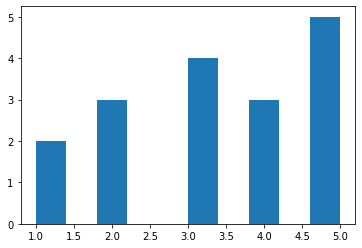

In [59]:
import matplotlib.pyplot  as plt
plt.hist(array)

<BarContainer object of 5 artists>

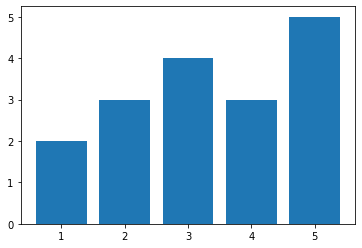

In [60]:
plt.bar(array_dist.keys(),array_dist.values())

In [61]:
prices_values = df_clean_products['price'].tolist()
prices_hist, prices_edges = np.histogram(prices_values,density=True, bins=20)
show(hist('All Prices',prices_hist,prices_edges))

count    3287.000000
mean       21.856641
std        29.847908
min        -1.000000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: price, dtype: float64

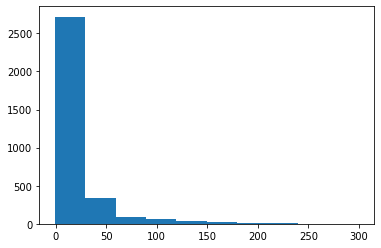

In [62]:
import matplotlib.pyplot as plt
plt.hist(df_products['price'])
df_products['price'].describe()

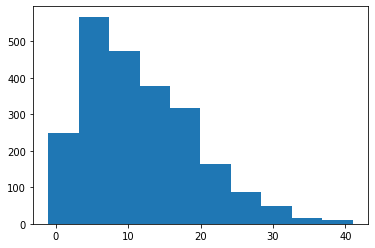

In [63]:
#df_product['categ'].value_counts(dropna=False)
plt.hist(df_products[df_products['categ']==0]['price'])
plt.show()

In [64]:
df_products[df_products['categ']==0]['price'].describe()

count    2309.000000
mean       11.727280
std         7.568756
min        -1.000000
25%         5.580000
50%        10.320000
75%        16.650000
max        40.990000
Name: price, dtype: float64

# Nettoyage Table Transactions

In [65]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [66]:
df_clean_transaction=df_transactions[df_transactions['session_id']!='s_0']
df_clean_transaction=df_clean_transaction[~df_clean_transaction['id_prod'].isin(transaid_notin_prod)]

dates=df_clean_transaction['date'].tolist()
dates=[date[:10] for date in dates]
df_clean_transaction['date']=dates

df_clean_transaction.to_csv('./cleaned_data/clean_transactions.csv',index=False)
print('Nombre de données Test : {}'.format(len(df_transactions[df_transactions['session_id']=='s_0'])))
print('Nombre de produits non présents dans la table produits : {}'.format(len(df_transactions[df_transactions['id_prod'].isin(transaid_notin_prod)])))
print()
df_clean_transaction.info()

Nombre de données Test : 200
Nombre de produits non présents dans la table produits : 221

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679111 non-null  object
 1   date        679111 non-null  object
 2   session_id  679111 non-null  object
 3   client_id   679111 non-null  object
dtypes: object(4)
memory usage: 25.9+ MB


In [67]:
df_transactions[df_transactions['session_id']==transaid_notin_prod[0]]

,id_prod,date,session_id,client_id


In [68]:
df_clean_transaction['date'].head(3)

0    2022-05-20
1    2022-02-02
2    2022-06-18
Name: date, dtype: object

In [69]:
dates=df_clean_transaction['date'].tolist()
dates=[date[:10] for date in dates]
df_clean_transaction['date']=dates
df_clean_transaction.head(3)

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20,s_211425,c_103
1,1_251,2022-02-02,s_158752,c_8534
2,0_1277,2022-06-18,s_225667,c_6714


# Nettoyage Table Customers

In [70]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [71]:
df_clean_customers=df_customers[~df_customers['client_id'].isin(customercid_notin_transac)]
df_clean_customers.to_csv('./cleaned_data/clean_customers.csv',index=False)
print('Nombre de client_id non présent dans la table transaction : {}'.format(len(customercid_notin_transac)))
print()
df_clean_customers.info()

Nombre de client_id non présent dans la table transaction : 21

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8602 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8602 non-null   object
 1   sex        8602 non-null   object
 2   birth      8602 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 268.8+ KB


# Nettoyage Table Products

In [72]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [73]:
df_clean_products=df_products[df_products['id_prod']!='T_0']
df_clean_products=df_clean_products[~df_clean_products['id_prod'].isin(productid_notin_transa)]
df_clean_products.to_csv("./cleaned_data/clean_products.csv",index=False)
print('Nombre de product_id non présent dans la table transaction : {}'.format(len(productid_notin_transa)))
print('Nombre de lignes "produits test" : 1')
print()
df_clean_products.info()

Nombre de product_id non présent dans la table transaction : 21
Nombre de lignes "produits test" : 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3265 non-null   object 
 1   price    3265 non-null   float64
 2   categ    3265 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.0+ KB
